# Extracting a DFallpa [for Lucas. Xuan can ignore]

In [ ]:
from neuralmonkey.classes.population_mult import dfallpa_extraction_load_wrapper
animal = "Diego"
date = 230615
question = "SP_shape_loc"
list_time_windows = [(-0.4, 0.6)]
events_keep = ["03_samp"]
combine_into_larger_areas = False
DFallpa = dfallpa_extraction_load_wrapper(animal, date, question, list_time_windows,
                                events_keep = events_keep,
                                HACK_RENAME_SHAPES=False)

In [ ]:
# Load a question
from neuralmonkey.analyses.rsa import rsagood_questions_dict
DictParamsEachQuestion = rsagood_questions_dict(animal, date)
q_params = DictParamsEachQuestion[question]
print(q_params)

In [ ]:
# Normalize, etc
# Clean up DFallpa
from neuralmonkey.analyses.rsa import preprocess_rsa_prepare_popanal_wrapper, popanal_preprocess_scalar_normalization

subtract_mean_each_level_of_var = None
plot_example_chan = None

list_pa =[]
list_panorm = []
for pa in DFallpa["pa"].tolist():
    print(pa.X.shape)
    pa, res_check_tasksets, res_check_effectvars = preprocess_rsa_prepare_popanal_wrapper(pa, **q_params)
    print(pa.X.shape)

    panorm, _, _, _, _, _ = popanal_preprocess_scalar_normalization(pa, q_params["effect_vars"],
                                                                                  subtract_mean_each_level_of_var)
    
    list_pa.append(pa)
    list_panorm.append(panorm)
    
DFallpa["pa"] = list_pa
DFallpa["pa_norm"] = list_panorm


In [ ]:
# Save it
import pickle
path = "/gorilla4/Dropbox/SCIENCE/FREIWALD_LAB/DATA/for_xuan/DFallpa.pkl"
with open(path, "wb") as f:
    pickle.dump(DFallpa, f)
print("Saved to:", path)

# Load a dataset

To load and plot a dataset of neural activity across population, in a PopAnal class object.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# this is the path to the dataset
# path = '/gorilla1/analyses/recordings/main/RSA/Diego-230615/agg_True-subtr_None-dist_euclidian_unbiased/SP_shape_loc/DFallpa.pkl'
path = "/gorilla4/Dropbox/SCIENCE/FREIWALD_LAB/DATA/for_xuan/DFallpa.pkl"


In [3]:
DFallpa = pd.read_pickle(path)


# EXAMPLE CODE for preprocessing of data

In [ ]:
# Get a PA, just for example
pa = DFallpa["pa"].values[0]

In [ ]:
# 1. First slice to time winodw, then take mean over time, i.e. a single time average
twind = (0.1, 0.5)
pa_sliced = pa.slice_by_dim_values_wrapper("times", twind)
pa_mean = pa_sliced.agg_wrapper("times")

print("Compare and see that times are binned")
print("-- original:", pa.Times, "... data shape: ", pa.X.shape)
print("-- sliced:", pa_sliced.Times, "... data shape: ", pa_sliced.X.shape)
print("-- mean:", pa_mean.Times, "... data shape: ", pa_mean.X.shape)


In [ ]:
# 2. binning time windows
binsize = 0.1
binslide = 0.02
pa_binned = pa.agg_by_time_windows_binned(binsize, binslide)
    
print("Compare and see that times are binned")
print("-- original:", pa.Times, "... data shape: ", pa.X.shape)
print("-- sliced:", pa_binned.Times, "... data shape: ", pa_binned.X.shape)


# Code example for benchmarking: decoding shapes

This step takes in a representation of neural data and outputs a scalar score for how well you can decode "shape" from that data

Here, this example is using the raw data (dimensionality = number of channels). The goal is to use methods to reduce the dimensionality of this data, each time running through this decoding benchmark, to compare the different methods

##### First, pull out a specific PA. (just an example)

NOTE: tjhis is just for demonstration. Eventually you will want to loop thru all PA, scoring them all

In [10]:
def extract_single_pa(DFallpa, bregion, twind):
    which_level = "trial"
    event = "03_samp"

    a = DFallpa["which_level"]==which_level
    b = DFallpa["event"]==event
    c = DFallpa["bregion"]==bregion
    d = DFallpa["twind"]==twind
    
    tmp = DFallpa[a & b & c & d]
    assert len(tmp)==1
    pa = tmp["pa"].values[0]
    
    return pa
    

In [ ]:
### PARAMS
bregion = "PMv_m"
twind = (0.3, 0.5)

### RUN
pa = extract_single_pa(DFallpa, bregion, twind)

nchans = pa.X.shape[0]
ntrials = pa.X.shape[1]
ntimes = pa.X.shape[2]

print("Shape of this dataset (chans, trials, times):", nchans, ntrials, ntimes)
print("Data is stored in pa.X: ", pa.X.shape)

##### Finally, extract the data that goes into the decoder

Extract activity wthin a specific time bin. Eventualy, you would want to test all time bins.

In [ ]:
tbin = 0
X = pa.X[:, :, tbin].T # (ntrials, nchans)
print(X.shape)

The variable you are trying to decode/predict is the shape on each trial.

In [ ]:
var = "seqc_0_shape"
shapes = pa.Xlabels["trials"][var].tolist()

print(shapes[:5])
print(len(shapes))

##### Train and test decoder

This is using a helper function I wrote (_model_fit) but you should go into the code to know how it works

In [ ]:
from neuralmonkey.population.classify import _model_fit

model_params_optimal = {"C":0.01} # optimized regularization params
pipe, score = _model_fit(X, shapes, model_params=model_params_optimal, do_center=True, do_std=False)

print("Model score (prediction accuracy on held-out test data):", score)

In [ ]:
print("Expected score if guessing = ", 1/len(set(shapes)))

In [ ]:
PAnorm.plotNeurHeat(0)

In [ ]:
pa.plotNeurHeat(0)

# LT added 2/15/24

## 1) Make sure to normalize PA before running any modeling on it:

In [ ]:
list_panorm = []
for pa in DFallpa["pa"].tolist():
    from neuralmonkey.analyses.state_space_good import popanal_preprocess_scalar_normalization
    PAnorm, PAscal, PAscalagg, fig, axes, groupdict = popanal_preprocess_scalar_normalization(pa, None, DO_AGG_TRIALS=False)
    list_panorm.append(PAnorm)
DFallpa["pa"] = list_panorm
del DFallpa["pa_norm"]

## 2) Code to plot neural trajectories in lower dimensions, colored and split by variables of interest

(<Figure size 1050x700 with 6 Axes>,
 array([[<Axes: title={'center': '(0, 0)'}>,
         <Axes: title={'center': '(0, 1)'}>,
         <Axes: title={'center': '(1, 0)'}>],
        [<Axes: title={'center': '(1, 1)'}>, <Axes: >, <Axes: >]],
       dtype=object))

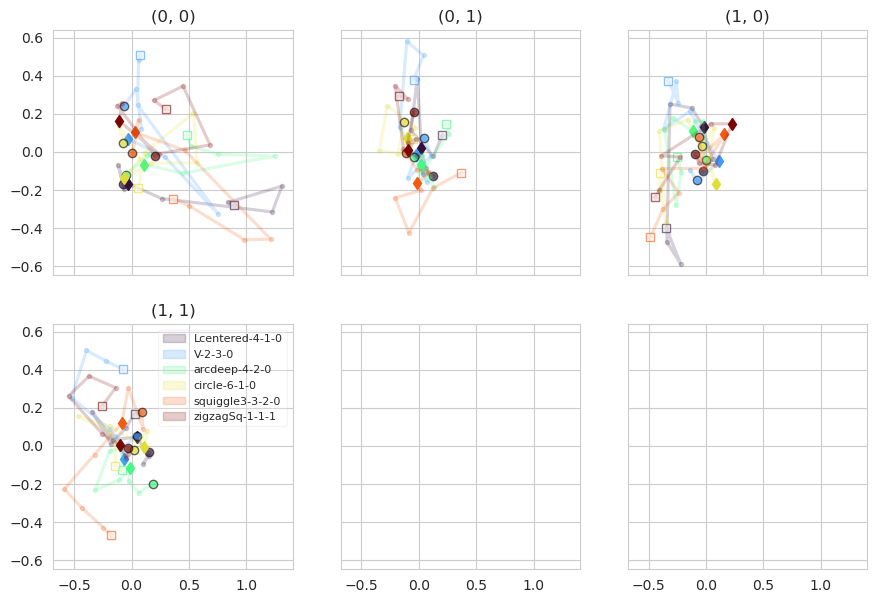

In [24]:
from neuralmonkey.analyses.state_space_good import trajgood_construct_df_from_raw, trajgood_plot_colorby_splotby

# Plot an example brain region's data.
bregion = "PMv"
twind = (-0.4, 0.6)
pa = extract_single_pa(DFallpa, bregion, twind)

# INPUT PARAMS
var_color_by = "seqc_0_shape"
var_subplots = "seqc_0_loc"

# Runs

# 1) Construct dataframe
# df = pa.dataextract_split_by_label_grp_for_statespace(grpvars)
grpvars = [var_color_by, var_subplots]
X = pa.X # (chans, trials, times)
labels = pa.Xlabels["trials"].loc[:, grpvars] 
labelvars = grpvars
df = trajgood_construct_df_from_raw(X, pa.Times, labels, labelvars)

# 2) Plot
dims = (0,1) # pairs of dimensions to plot
times_to_mark = [0.] # you can mark specific times on the plot. here marks the 0. sec mark.
times_to_mark_markers = ["d"] # mark with a diamond ("d")
time_bin_size = 0.1 # to make plot easier to visaulize, you can bin in time.
trajgood_plot_colorby_splotby(df, var_color_by, var_subplots, dims, "traj", mean_over_trials=True,
                              times_to_mark = times_to_mark, times_to_mark_markers = times_to_mark_markers,
                              time_bin_size=time_bin_size)

(<Figure size 1050x700 with 6 Axes>,
 array([[<Axes: title={'center': 'Lcentered-4-1-0'}>,
         <Axes: title={'center': 'V-2-3-0'}>,
         <Axes: title={'center': 'arcdeep-4-2-0'}>],
        [<Axes: title={'center': 'circle-6-1-0'}>,
         <Axes: title={'center': 'squiggle3-3-2-0'}>,
         <Axes: title={'center': 'zigzagSq-1-1-1'}>]], dtype=object))

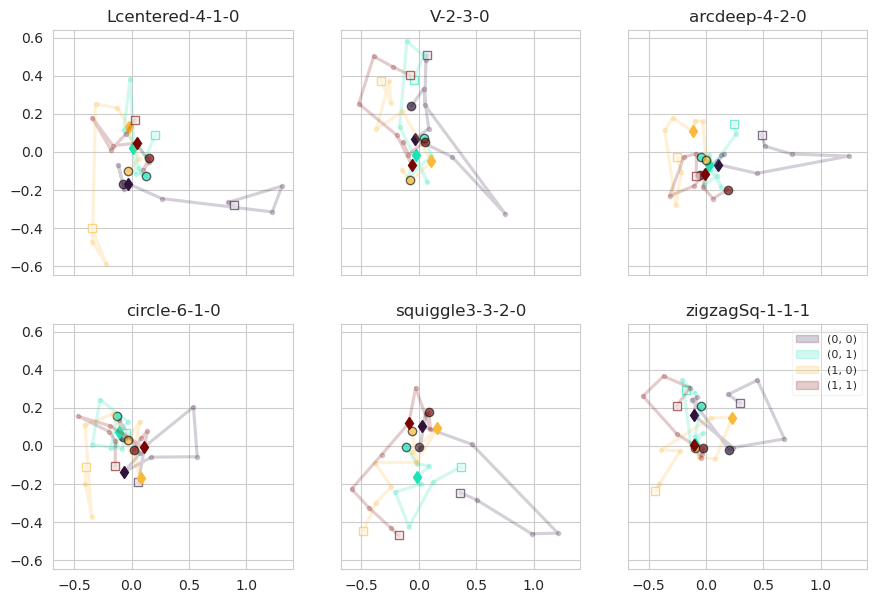

In [25]:
# Same, but coloring by location

var_color_by = "seqc_0_loc"
var_subplots = "seqc_0_shape"

# 1) Construct dataframe
# df = pa.dataextract_split_by_label_grp_for_statespace(grpvars)
grpvars = [var_color_by, var_subplots]
X = pa.X # (chans, trials, times)
labels = pa.Xlabels["trials"].loc[:, grpvars] 
labelvars = grpvars
df = trajgood_construct_df_from_raw(X, pa.Times, labels, labelvars)

# 2) Plot
dims = (0,1) # pairs of dimensions to plot
times_to_mark = [0.] # you can mark specific times on the plot. here marks the 0. sec mark.
times_to_mark_markers = ["d"] # mark with a diamond ("d")
time_bin_size = 0.1 # to make plot easier to visaulize, you can bin in time.
trajgood_plot_colorby_splotby(df, var_color_by, var_subplots, dims, "traj", mean_over_trials=True,
                              times_to_mark = times_to_mark, times_to_mark_markers = times_to_mark_markers,
                              time_bin_size=time_bin_size)

## 3) Score and plot decoding accuracy

1. Try different methods for dim reduction of X. In all cases, if X is shape (nchans, ntrials, ntimes), dim reduction should return Xreduced of shape (ndim, ntrials, ntimes) where ndim < nchans
2. For the benchmark decoder, you want to score looping through each bregion, twind, and tbin. i.e, see below

In [ ]:
list_dim_reduction_methods = ["pca", "CEBRA"] # FILL THIS IN

In [26]:
HACK = True # quickly run to see what it's like, without any dim reduction methods

if HACK:
    list_dim_reduction_methods = ["IGNORE"]

In [59]:
def compute_decode_score(x, labels, max_nsplits=5):
    """
    Score decoding accuracy
    """
    from neuralmonkey.analyses.decode_good import decode_categorical_wrapper
    from neuralmonkey.population.classify import _model_fit
    import numpy as np
    
    assert x.shape[0]==len(labels)
    assert len(x.shape)==2
    
    res = decode_categorical_wrapper(Xreduced_this_time_bin, labels, 3, max_nsplits=max_nsplits)
    # get mean score across splits
    return np.mean([r["score_xval"] for r in res])
    

In [58]:
from neuralmonkey.utils.frmat import bin_frmat_in_time


(42, 422, 100)
(422, 45)


In [61]:
list_br = DFallpa["bregion"].unique().tolist()
list_tw = DFallpa["twind"].unique().tolist()

res = []

list_vars_decode = ["seqc_0_shape", "seqc_0_loc"]

for br in list_br:
    for tw in list_tw:
        # 1. Extract the specific pa for this (br, tw)
        pa = extract_single_pa(DFallpa, br, tw)
        
        # 2. Extract X from pa
        X = pa.X # (nchans, ntrials, ntimes)
        times = pa.Times
        
        # Optionally, bin X in time, to have fewer time bins to decode
        X, times = bin_frmat_in_time(X, times, time_bin_size=0.1, slide=0.02)

        list_tbin = range(X.shape[2])
        for method in list_dim_reduction_methods:
            print(br, tw, method)
            # 2. Apply this method to pa
            if HACK:
                Xreduced = X
            else:
                Xreduced = dim_reduce(X, method) # FILL THIS IN
            
            for tbin in list_tbin:
                # 3a. Extract data for this time bin
                Xreduced_this_time_bin = Xreduced[:, :, tbin].T # (ntrials, nchans)                    
    
                # 3. Run decoder
                for var_decode in list_vars_decode:
                    # labels = pa.Xlabels["trials"][var_decode].tolist()
                    labels = pd.factorize(pa.Xlabels["trials"][var_decode])[0]
                    score = compute_decode_score(Xreduced_this_time_bin, labels) # FILL THIS IN
                
                    # 3. Collect data
                    res.append({
                        "method":method,
                        "bregion":br,
                        "twind":tw,
                        "tbin":tbin,
                        "time":times[tbin],
                        "var_decode":var_decode,
                        "score":score
                    })

dfres = pd.DataFrame(res)
     

M1 (-0.4, 0.6) IGNORE
PMv (-0.4, 0.6) IGNORE
PMd (-0.4, 0.6) IGNORE
dlPFC (-0.4, 0.6) IGNORE
vlPFC (-0.4, 0.6) IGNORE
FP (-0.4, 0.6) IGNORE
SMA (-0.4, 0.6) IGNORE
preSMA (-0.4, 0.6) IGNORE


In [63]:
dfres[:5]

,method,bregion,twind,tbin,time,var_decode,score
0,IGNORE,M1,"(-0.4, 0.6)",0,-0.345,seqc_0_shape,0.158407
1,IGNORE,M1,"(-0.4, 0.6)",0,-0.345,seqc_0_loc,0.252568
2,IGNORE,M1,"(-0.4, 0.6)",1,-0.325,seqc_0_shape,0.158687
3,IGNORE,M1,"(-0.4, 0.6)",1,-0.325,seqc_0_loc,0.248596
4,IGNORE,M1,"(-0.4, 0.6)",2,-0.305,seqc_0_shape,0.179817


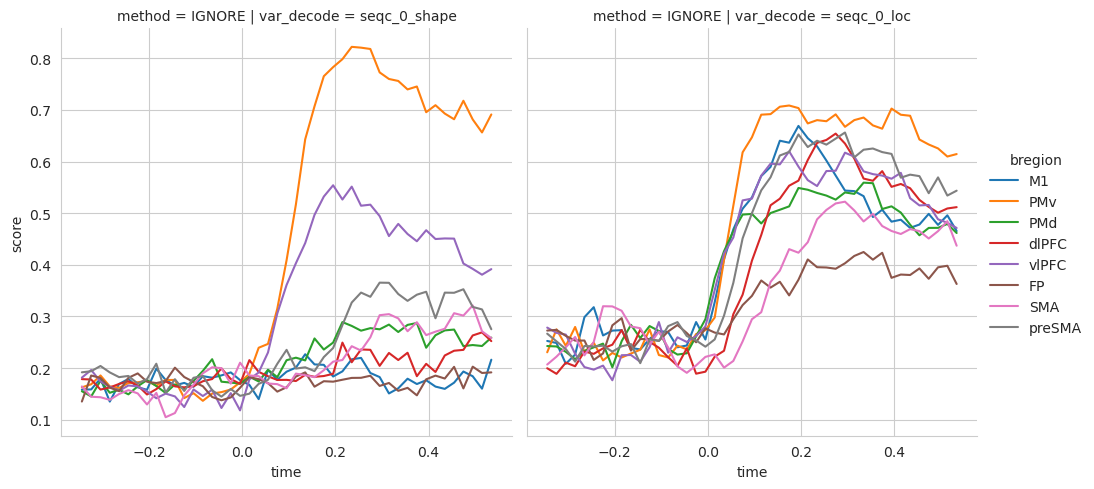

In [62]:
%matplotlib inline
##### Plot the results, comparing score across methods!!
import seaborn as sns
fig = sns.relplot(data=dfres, x="time", y="score", hue="bregion", col="var_decode", row="method", kind="line")

